# PHT Eclipsing Binary Catalog

- data covered: sectors 1 - 39 (2 years of Southern hemisphere and 1 year of Northern hemisphere)

In [3]:
from importlib import reload

from IPython.display import display, HTML, clear_output

import numpy as np

import pandas as pd
from pandas.io.clipboard import clipboard_set

import matplotlib.pyplot as plt

import catalog
import catalog_stats
import dashboard_utils
from dashboard_utils import CAT_COLS_COMMON
from dashboard_utils import two_columns

display(HTML("<style>.container { width:99% !important; }</style>"))

## Tagging accuracy and Catalog coverage

In [4]:
# reload(catalog_stats)
# reload(dashboard_utils)

df_catalog = dashboard_utils.get_catalog("pht_eb")

grid, col1, col2 = two_columns(also_return_outputs=True)

with col1:
    report, styler = catalog_stats.pivot_by_eb_score_group(df_catalog, also_return_styler=True)
    display(styler)

with col2:
    ax = report[report.index != "Totals"].plot.pie(y=('count', 'tic_id', 'Totals'));
    ax.set_title("TIC distribution by eb_score_group")
    plt.close(1)  # hide the plot outside the grid
    display(ax.get_figure())


display(grid);

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

### A rough estimate of the number of new eclipsing binaries
- i.e., not listed in the catalogs matched

In [5]:
# reload(catalog_stats)

# use min_eb_score=3 , as it's the threshold that proxy accuracy >= 90%
res, report, styler = catalog_stats.estimate_num_ebs_not_in_catalog(df_catalog, min_eb_score=3);
display(styler)
display(HTML(f"""Estimated number of EBs not in catalogs matched = 
<span style="background: rgba(255, 255, 0, 0.8)">{res.num_eb_not_in_catalog}</span>
&emsp;({res.num_not_classified} &times; {res.proxy_accuracy:.2%})
"""))

## Coverage of individual catalogs

In [6]:
report_simbad, styler_simbad = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="SIMBAD_Is_EB", also_return_styler=True)
# display(report_simbad[report_simbad.index == "Totals"])
display(two_columns(styler_simbad, styler))

report_vsx, styler_vsx = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="VSX_Is_EB", also_return_styler=True)
# display(report_vsx[report_vsx.index == "Totals"])
display(two_columns(styler_vsx, styler))

report_asas_sn, styler_asas_sn = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="ASASSN_Is_EB", also_return_styler=True)
# display(report_vsx[report_asas_sn.index == "Totals"])
display(two_columns(styler_asas_sn, styler))

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

### Compare raw number of EB votes vs adjusted eb_score 
- can we just use raw `num_votes_eb`, rather than adjusted `eb_score`, to gauge the likelihood of TIC being an eclipsing binary?

In [9]:
report_by_vote, styler_by_vote = catalog_stats.pivot_by_eb_score_group(df_catalog, index="num_votes_eb_group", also_return_styler=True)
styler_by_vote = styler_by_vote.set_caption("By raw num. of EB votes")
report, styler = catalog_stats.pivot_by_eb_score_group(df_catalog, index="eb_score_group", recalc_group=True, also_return_styler=True)
styler = styler.set_caption("By eb_score")
display(two_columns(styler_by_vote, styler))

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

## Sample TICs

In [11]:
reload(dashboard_utils)

df = df_catalog
df = (
    df
    [df["is_eb_catalog"] == "F"]
    .groupby("eb_score_group")
    .head(2)
    .sort_values(["eb_score_group"], ascending=[False])
    )
# clipboard_set(df[CAT_COLS_COMMON].to_markdown())
# df[CAT_COLS_COMMON].to_clipboard()

# dashboard_utils.style(df[CAT_COLS_COMMON])
dashboard_utils.style(df[["best_subject_img_id", ] + CAT_COLS_COMMON], show_thumbnail=True)

best_subject_img_id,tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_OTYPES,SIMBAD_Is_EB,VSX_OID,VSX_Type,VSX_Is_EB,VSX_Period,ASASSN_Name,ASASSN_URL,ASASSN_Type,ASASSN_Per,TESSEB
,143669444,32026607,F,11,HD 64881,,-,409787,ACV|ELL,F,1.103900,J075359.20-453838.0,details,VAR,274.249967,details
,198537349,44563986,F,7,HD 141988,,-,58848,nan,-,nan,J154830.03+622040.8,details,ROT:,0.000000,details
,4200337,56365918,F,6,nan,nan,-,371037,BY,F,8.164117,J052244.88-010231.9,details,ROT,8.152767,details
,77209028,30249806,F,6,CD-38 1652,V*|X|Ro*,F,280953,ROT,F,0.568900,J043558.78-384134.0,details,VAR,0.000000,details
,17342647,48229829,F,5,HD 144359,UV,-,1546101,HB,F,4.382000,nan,nan,nan,nan,details
,29854488,52580003,F,5,nan,nan,-,,nan,-,nan,J013616.50-105235.0,details,ROT,2.300860,details
,22120766,41413067,F,4,CD-23 8836,V*|X|Ro*,F,90404,ROT,F,1.668000,J095357.05-240846.9,details,ROT:,0.000000,details
,22221233,41410027,F,4,TYC 6604-717-1,,-,,nan,-,nan,J095556.28-240307.8,details,ROT:,0.000000,details
,52357,64613852,F,3,HD 129195,V*,-,58594,VAR,-,0.377800,J144157.16-280357.6,details,L,0.000000,details
,8669966,48223652,F,3,* 32 Her,**|SB*|UV,-,59130,ELL+DSCT,F,3.394306,J163329.10+302956.2,details,ROT:,0.000000,details


In [13]:
dashboard_utils.display_details(
    tic_id=10111251, 
    type="tic_meta",
    brief=True,
)
plt.close(1);  # hide the plot outside the grid

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

### Analyzing TICs that are potentially mistagged

- `is_eb_catalog == "F"`, i.e., those that are listed in catalogs, but classified as something could indicate being indicated
    - current definiton primarily various pulsators and rotators
- The breakdown enables one to review TICs in group to see if they are indeed mistagged.
    

In [10]:
df = df_catalog
df_summary = (
    df
    [(df["is_eb_catalog"] == "F") & (df["eb_score"] >= 2)]  # -np.inf  # to show all 
    .pivot_table(
        index="VSX_Type", 
#         index="ASASSN_Type", 
#         index="SIMBAD_OTYPES", 
        columns="eb_score_group", values="tic_id", aggfunc="count", margins=True)
#     .groupby("VSX_Type")
#     [["tic_id"]]
#     .count()
    .sort_values(["All"], ascending=[False])
    )
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_summary)

eb_score_group,02,03,04,05,06,07+,All
VSX_Type,,,,,,,
All,200.0,65.0,41.0,21.0,11.0,2.0,340
ROT,32.0,11.0,10.0,7.0,3.0,NaN,63
ACV,18.0,9.0,2.0,NaN,NaN,NaN,29
DSCT,18.0,4.0,1.0,NaN,NaN,NaN,23
VAR,7.0,5.0,5.0,3.0,1.0,NaN,21
ELL,11.0,4.0,3.0,1.0,1.0,NaN,20
HADS,16.0,1.0,1.0,NaN,NaN,NaN,18
BY,10.0,1.0,2.0,2.0,2.0,NaN,17
RS,7.0,3.0,2.0,NaN,1.0,NaN,13


## EB Candidates Map

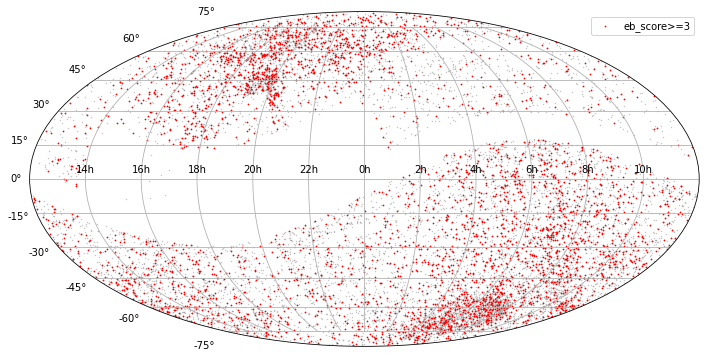

<Figure size 864x648 with 0 Axes>

In [16]:
ax = dashboard_utils.plot_skymap(df_catalog, projection="mollweide");  # projection="lambert"
# highlight the better quality ones
ax = dashboard_utils.plot_skymap(df_catalog[df_catalog["eb_score"] >= 3], ax=ax, scatter_kwargs=dict(c="red", s=0.5, label="eb_score>=3"));
ax.legend();